In [1]:
"""Installations pour faire des cartes"""
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install geopandas
!pip install topojson

In [2]:
"""Librairies nécessaires"""
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

In [6]:
"""Commandes (optionnelles) si le fichier n'est pas trouvé par la suite:

import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Projet-Stat-App-2A') #changer le directory

remarques sur github, commandes du terminal :
- ls : lister 
- cd : change directory 
    cd projet-stat-app-2A

"""

In [7]:
"""Installation de cartiflette dans le terminal"""

!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a


  Cloning https://github.com/inseefrlab/cartiflette (to revision 80b8a5a28371feb6df31d55bcc2617948a5f9b1a) to /tmp/pip-req-build-vab3p5_b
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-vab3p5_b
  Running command git rev-parse -q --verify 'sha^80b8a5a28371feb6df31d55bcc2617948a5f9b1a'
  Running command git fetch -q https://github.com/inseefrlab/cartiflette 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Running command git checkout -q 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Resolved https://github.com/inseefrlab/cartiflette to commit 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [8]:
"""Installation de cartiflette"""
from cartiflette.s3 import download_vectorfile_url_all

In [10]:
"""Données administratives de paris intra muros"""
paris_intra_muros = download_vectorfile_url_all(
    crs = 4326,
    values = ["75"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=75/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 40.1kiB [00:00, 41.6MiB/s]


In [27]:
def carte_prix_moyen_arrodissement(emplacement, année):
    #emplacement : emplacement du fichier (string)
    #année : année considérée (string)
    
    #lecture du fichier
    df = pd.read_csv(emplacement)

    #conversion du fichier en geopanda
    df_geo = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="WGS84"
        )

    #on ajoute à chaque appartement les données administratives de son arrondissement
    df_geo = gpd.sjoin(df_geo, paris_intra_muros, predicate = 'within')

    #regroupement selon les arrondissements et prix moyen au m2
    df_geo_group = (df_geo
      .groupby("INSEE_COG")
      .agg({"prix_au_m2_réel": "mean"})
      .reset_index())

    #on ajoute aux données administratives les prix moyens
    paris_intra_muros_count = paris_intra_muros.merge(
        df_geo_group
    ).to_crs(2154)

    #affichage de la carte
    paris_intra_muros_count.plot(
    column = "prix_au_m2_réel", cmap="coolwarm", legend=True
    )

    plt.title(f'Prix moyen du m^2 par arrondissement en {année}') 
    plt.xticks([], [])
    plt.yticks([], [])
    plt.savefig(f"Visualisation/Prix moyen par arrondissement en {année}.png", dpi=300)

/opt/mamba/lib/python3.10/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


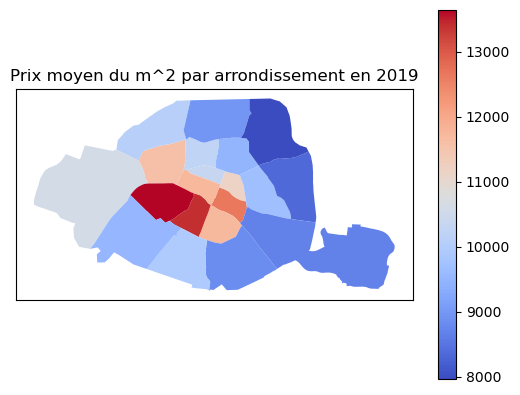

In [32]:
"""Test de la fonction"""

emplacement = "Données_clean/DVF_75_2019_clean.csv"
année = '2019'

carte_prix_moyen_arrodissement(emplacement, année)

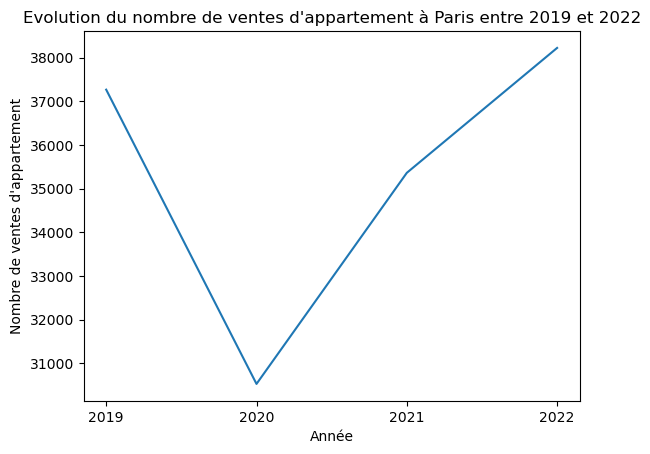

In [45]:
#évolution du nombre de ventes entre 2019 et 2022
liste_nb_ventes = []
liste_années = []

for année in [2019,2020,2021,2022]:
    df = pd.read_csv(f"Données_clean/DVF_75_{année}_clean.csv")
    liste_nb_ventes.append(df.shape[0])
    liste_années.append(année)

plt.plot(liste_années, liste_nb_ventes)
plt.title("Evolution du nombre de ventes d'appartement à Paris entre 2019 et 2022")
plt.xlabel("Année")
plt.ylabel("Nombre de ventes d'appartement")
plt.xticks([2019, 2020, 2021, 2022])
plt.savefig("Evolution nombre ventes 2019-2022.png", dpi=300)